In [1]:
## Import libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
## Reference frequency
omega = 106.69842

## Need to grab period from config files
T5 = 0.058522272895753
T9 = 0.058522272895753

## Need to grab frequencies from config file
omega5 = [0, 107.364,-107.364, 276.886,-276.886]
omega9 = [0, 107.364,-107.364, 214.782,-214.782, 276.886,-276.886, 384.25,-384.25]

In [3]:
## Get data from file
#  2-harmonics pitch + 1-harmonic plunge
unsteady_df = pd.read_csv('2dof/Unsteady/history.csv').rename(columns=lambda x: x.strip())
hb5_df = pd.read_csv('2dof/HB/HB5/HB_output.csv',index_col=False)
hb9_df = pd.read_csv('2dof/HB/HB9/HB_output.csv',index_col=False)

/tmp/ipykernel_3804537/1011105753.py:4: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  hb5_df = pd.read_csv('2dof/HB/HB5/HB_output.csv',index_col=False)
/tmp/ipykernel_3804537/1011105753.py:5: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  hb9_df = pd.read_csv('2dof/HB/HB9/HB_output.csv',index_col=False)


In [4]:
## Process data
all_times = unsteady_df['"Cur_Time"'].to_numpy()*omega
all_lift = unsteady_df['"CL"'].to_numpy()

N5 = len(hb5_df['time_instance'])
hb5_times = hb5_df['time_instance'].to_numpy()*T5*omega/N5
hb5_lift = hb5_df['CL'].to_numpy()

N9 = len(hb9_df['time_instance'])
hb9_times = hb9_df['time_instance'].to_numpy()*T9*omega/N9
hb9_lift = hb9_df['CL'].to_numpy()

In [5]:
## Define functions for Einv and interpolation

#  Einv calculation
def get_Einv(T,N,K,omegas):
    Einv = np.zeros((N,K),dtype=complex)
    for n in range(0,N):
        for k in range(0,K):
            Einv[n,k] = complex(np.cos(omegas[k]*n*T/N),np.sin(omegas[k]*n*T/N))
    return Einv

#  Interpolation
def get_interp(T,max_time,n_times,omegas,hb_lift):
    Einv = get_Einv(T,len(omegas),len(omegas),omegas)
    coeffs = np.squeeze(np.asarray(np.mat(np.linalg.inv(Einv))*np.mat(hb_lift).transpose()))
    times = np.linspace(0,max_time,num=n_times)
    interpol = np.zeros(len(times))
    for i in range(0,len(times)):
        for k in range(0,len(coeffs)):
            interpol[i] = interpol[i] + coeffs[k]*complex(np.cos(omegas[k]*times[i]),np.sin(omegas[k]*times[i]))
    return times,interpol

In [6]:
## Number of time points to interpolate
n_times = 10000

## Get interpolated values
t5,i5 = get_interp(T5,max(all_times)/omega,n_times,omega5,hb5_lift)
t9,i9 = get_interp(T9,max(all_times)/omega,n_times,omega9,hb9_lift)

/tmp/ipykernel_3804537/2109888424.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
  interpol[i] = interpol[i] + coeffs[k]*complex(np.cos(omegas[k]*times[i]),np.sin(omegas[k]*times[i]))


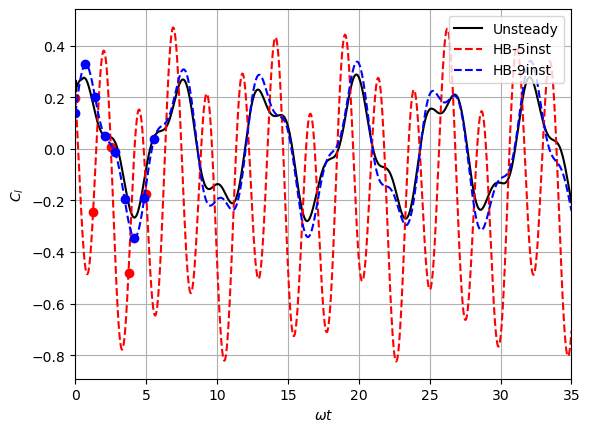

In [7]:
## Plot unsteady
plt.plot(all_times,all_lift,'-k',label='Unsteady')

## Plot for HB-5inst
plt.plot(hb5_times,hb5_lift,'or',label='_hb5')
plt.plot(t5*omega,i5,'--r',label='HB-5inst')

## Plot for HB-9inst
plt.plot(hb9_times,hb9_lift,'ob',label='_hb9')
plt.plot(t9*omega,i9,'--b',label='HB-9inst')

plt.xlim([0, 35])

plt.grid()
plt.xlabel('$\omega t$');
plt.ylabel('$C_l$');
plt.legend(loc='upper right');